# Stock Sentiment Analysis of 10K filings using NLP and Vador

A 10-K is a comprehensive report filed annually by a publicly-traded company about its financial performance and is required by the U.S. Securities and Exchange Commission (SEC). The report contains much more detail than a company's annual report, which is sent to its shareholders before an annual meeting to elect company directors

Although, the report contains a lot of information about the company only the following sections were analysed for sentiment:
- Item 1 - Business
- Item 1A - Risk Factors
- Item 7 - Management's Discussion and Analyssi of Financial Conditions
- Item 7A - Quantitative and Qualitative Disclosure About the Market Risk

All the Data was obtained form SEC EDGAR database.

NLP analysis carried out following these steps:
- Download the html version of 10K report
- Clean the data from the HTML syntax
- Find the sections which we are intereseted in
- Remove unnecessary characters/punctuation/stop words
- Stemming
- Make text lower case
- Analyse sentiment using the Vader dictionary which has approx 7.5k words with sentiment assigned
- Sum the scores and calcualte the overall sentiment

In [1]:
import pandas as pd
import numpy as np
import re
import os
import glob
import nltk
import plotly.express as px
import matplotlib.pyplot as plt
import squarify 
import string

from bs4 import BeautifulSoup
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize.toktok import ToktokTokenizer
from sec_edgar_downloader import Downloader
from time import sleep
from tqdm import tqdm
print(os.getcwd())

C:\Users\user


In [2]:
# Import the filtered list of tickers from the "Stock Analysis Universe Filtering" module

%store -r universe_list
print(len(universe_list))

In [4]:
# Function to analyze the sentiment of a text

# Preparing a list of Stop Words to be removed from text
tokenizer = ToktokTokenizer( )
stopword_list = nltk.corpus.stopwords.words("english")
stopword_list.remove("no")
stopword_list.remove("not")

def analyze_sentiment(text):
    sentiment_score = sia.polarity_scores(text)
    return sentiment_score

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip( ) for token in tokens] # List comprehension: loop through every token and strip white space
    filtered_tokens = [token for token in tokens if token not in stopword_list] # Keep only the non stop word tokens in the list
    filtered_text = ' '.join(filtered_tokens) # join all those tokens using a space as a delimiter
    return filtered_text

In [5]:
# Downloading 10K Reports from the EDGAR SEC database

dl = Downloader()

for i in tqdm(universe_list):
    dl.get("10-K", i, amount=1) #amount=1  ==> the latest report is downloaded

  0%|                                                                                          | 0/302 [00:00<?, ?it/s]C:\Users\user\anaconda3\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 302/302 [23:14<00:00,  4.62s/it]


In [6]:
score_list = []

# Sentiment analysis

for i in tqdm(universe_list):
    try:
        path = glob.glob('C:\\Users\\user\\sec-edgar-filings\\' + str(i) + '\\10-K\\*\\full-submission.txt') # Find the appropriate file path
        path_str = ''.join(path)
        raw_text = open(path_str, "r")
        raw_txt = raw_text.read()
        
        # Finding the sections which we are interested in
        doc_start_pattern = re.compile(r'<DOCUMENT>') # Regex to find <DOCUMENT> tags
        doc_end_pattern = re.compile(r'</DOCUMENT>')# Regex to find <TYPE> tag prceeding any characters, terminating at new line
        type_pattern = re.compile(r'<TYPE>[^\n]+')
        doc_start_is = [x.end() for x in doc_start_pattern.finditer(raw_txt)]
        doc_end_is = [x.start() for x in doc_end_pattern.finditer(raw_txt)]
        doc_types = [x[len('<TYPE>'):] for x in type_pattern.findall(raw_txt)]

        document = {}
        # Create a loop to go through each section type and save only the 10-K section in the dictionary
        for doc_type, doc_start, doc_end in zip(doc_types, doc_start_is, doc_end_is):
            if doc_type == '10-K':
                document[doc_type] = raw_txt[doc_start:doc_end]
        regex = re.compile(r'(>Item(\s|&#160;|&nbsp;)(1A|1B|7A|7|8)\.{0,1})|(ITEM\s(1A|1B|7A|7|8))')

        # Use finditer to math the regex
        matches = regex.finditer(document['10-K'])
        # Create the dataframe
        test_df = pd.DataFrame([(x.group(), x.start(), x.end()) for x in matches])
        test_df.columns = ['item', 'start', 'end']
        test_df['item'] = test_df.item.str.lower()

        # Get rid of unnesesary charcters from the dataframe
        test_df.replace('&#160;',' ',regex=True,inplace=True)
        test_df.replace('&nbsp;',' ',regex=True,inplace=True)
        test_df.replace(' ','',regex=True,inplace=True)
        test_df.replace('\.','',regex=True,inplace=True)
        test_df.replace('>','',regex=True,inplace=True)
        pos_dat = test_df.sort_values('start', ascending=True).drop_duplicates(subset=['item'], keep='last') # Drop duplicates
        pos_dat.set_index('item', inplace=True)        # Set item as the dataframe index

        # Final Sections of Interest
        item_1a_raw = document['10-K'][pos_dat['start'].loc['item1a']:pos_dat['start'].loc['item1b']]# Get Item 1a
        item_7_raw = document['10-K'][pos_dat['start'].loc['item7']:pos_dat['start'].loc['item7a']] # Get Item 7
        item_7a_raw = document['10-K'][pos_dat['start'].loc['item7a']:pos_dat['start'].loc['item8']]# Get Item 7a

        ### First convert the raw text we have to exrtacted to BeautifulSoup object to clean HTML 
        item_1a_content = BeautifulSoup(item_1a_raw, 'lxml')
        item_7_content = BeautifulSoup(item_7_raw, 'lxml')
        item_7a_content = BeautifulSoup(item_7a_raw, 'lxml')
        ### Preparing text for cleaning
        clean_text_1a = item_1a_content.get_text("\n\n")
        clean_text_7 = item_7_content.get_text("\n\n")
        clean_text_7a = item_7a_content.get_text("\n\n")

        full_text = clean_text_1a + clean_text_7 + clean_text_7a

        # Further Cleaning 
        # Removing punctuation and Lower Casing
        punctuation = string.punctuation
        full_text = full_text.translate(str.maketrans('', '', punctuation))       
        full_text_lower = full_text.lower()
        # Remove Stop Words
        full_text_clean = remove_stopwords(full_text_lower, is_lower_case = True)

        # Create an instance of the sentiment intensity analyzer
        sia = SentimentIntensityAnalyzer()
        
        score_sub_list = []
        # Calcualting the sentiment score
        sentiment_scores = analyze_sentiment(full_text_clean)
        score_sub_list.append(i)
        score_sub_list.append(sentiment_scores['pos'])
        score_sub_list.append(sentiment_scores['neg'])
        score_sub_list.append(sentiment_scores['neu'])
        score_sub_list.append(sentiment_scores['compound'])
    except Exception: # Some errors were noted during testing which arise froma small number of reports not having the good format
        pass
    score_list.append(score_sub_list)

100%|████████████████████████████████████████████████████████████████████████████████| 302/302 [12:49<00:00,  2.55s/it]


In [8]:
# Create a DataFrame of scores

df_score_list = pd.DataFrame(score_list)
df_score_list = df_score_list.set_index(df_score_list.columns[0])
df_score_list.columns = ["Pos", "Neg", "Neut", "Comp"]
df_score_list["ScoreDiff"] = df_score_list["Pos"] - df_score_list["Neg"]
df_score_list

,Pos,Neg,Neut,Comp
0,,,,
CHX,0.181,0.106,0.713,1.0000
PLAB,0.129,0.101,0.770,0.9997
LYTS,0.153,0.139,0.708,0.9941
LYTS,0.153,0.139,0.708,0.9941
LYTS,0.153,0.139,0.708,0.9941
...,...,...,...,...
AVT,0.149,0.109,0.742,0.9998
SMCI,0.154,0.099,0.747,1.0000
VIAV,0.162,0.095,0.743,1.0000


In [11]:
# Calculating the difference beween the positive and negative sentiment

df_score_list["ScoreDiff"] = df_score_list["Pos"] - df_score_list["Neg"]
df_score_list = df_score_list.drop_duplicates()
df_score_list.describe()

,Pos,Neg,Neut,Comp,ScoreDiff
count,239.000000,239.000000,239.000000,239.000000,239.000000
mean,0.149540,0.100021,0.750473,0.894474,0.049519
std,0.038087,0.031875,0.029232,0.398045,0.063863
min,0.000000,0.032000,0.617000,-0.999300,-0.296000
25%,0.145000,0.087000,0.733000,0.999900,0.038000
50%,0.155000,0.099000,0.747000,1.000000,0.057000
75%,0.164500,0.109500,0.763000,1.000000,0.075500
max,0.245000,0.296000,0.896000,1.000000,0.201000


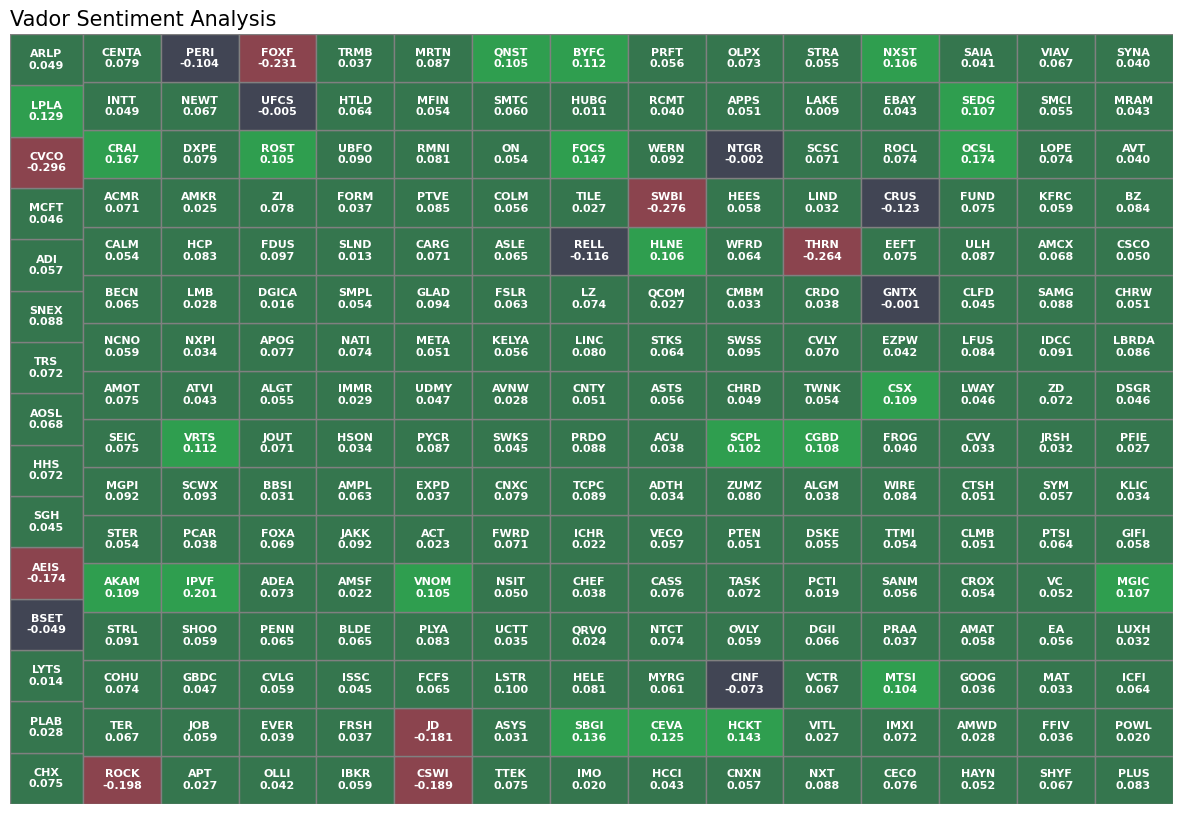

In [13]:
# Creating a heatmap based on the sentiment
# Green = Positiive
# Grey = Neutral
# Red = Negative

conditions = [df_score_list["ScoreDiff"] == 1,
                  (df_score_list["ScoreDiff"] <= 0.21) & (df_score_list["ScoreDiff"] > 0.10),
                  (df_score_list["ScoreDiff"] <= 0.10) & (df_score_list["ScoreDiff"] > 0),
                  (df_score_list["ScoreDiff"] <= 0) & (df_score_list["ScoreDiff"] > -0.15),
                  (df_score_list["ScoreDiff"] <= -0.15) & (df_score_list["ScoreDiff"] > -0.3)]
colors_codes = ['#30cc5a', '#2f9e4f', '#35764e',  '#414554', '#8b444e']
colors = np.select(conditions, colors_codes, default=np.nan)

plt.figure(figsize = (15, 10))
list_size = [1]*len(df_score_list)
squarify.plot(sizes = list_size,
                  label = [f'{symbol}\n{change:.3f}' for symbol, change in zip(df_score_list.index, df_score_list["ScoreDiff"])],
                  color = colors,
                  edgecolor = 'gray', 
                  text_kwargs = {'color': 'white', 'weight': 'bold', 'fontsize': 8})
plt.axis('off') 
plt.title("Vador Sentiment Analysis", loc = 'left', size = 15)
plt.show()

In [16]:
# Selecting 30 stocks with the highest sentiment 

df_score_list_30 = df_score_list.sort_values(by="ScoreDiff", ascending = False).head(30)
tickers_30 = list(set(df_score_list_30.index))
%store tickers_30

Stored 'tickers_30' (list)
